In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import datetime

start_time = datetime.datetime.now()

### USEFUL LINKS
* https://stackoverflow.com/questions/26942476/reading-csv-zipped-files-in-python
* https://www.youtube.com/watch?v=jT1ebRvLhz8
* https://pymotw.com/2/zipfile/
* https://github.com/pandas-dev/pandas/issues/18691
* https://stackoverflow.com/questions/1345827/how-do-i-find-the-time-difference-between-two-datetime-objects-in-python

In [3]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [4]:
def annual_median(zip_file):
    """Access a zip file and reads through the csv files in the zip file one by one.
        Computes median of the sum of the column 'total_obligation' according to year
        Returns the median, agency_id, file_size, and row_count of the file that was read in
    
    Args:
        zip_file (string)    : name of the zip file to be accessed
    
    Returns:
        median_list (list)   : List of the median values calculated
        agency_list (list)   : List of the agency_id's for each file
        file_size_list (list): List of the file_sizes for each file
        row_count_list (list): List of the row_counts for each file
    
    """
    award_zip = zipfile.ZipFile(zip_file)
    file_names = award_zip.namelist()[1:]
    median_list = []
    agency_list = []
    file_size_list = []
    row_count_list = []
    
    for i in range(len(file_names)):
        file_df = pd.read_csv(award_zip.open(file_names[i]), low_memory = False)
        file_df['period_of_performance_start_date'] = pd.to_datetime(file_df['period_of_performance_start_date'],
                                                                    errors = 'coerce')
        file_df['year'] = file_df['period_of_performance_start_date'].dt.year
        file_sum = file_df.groupby(['year'], as_index = False)['total_obligation'].sum()
        file_sum_median = file_sum['total_obligation'].median()
        
        median_list.append(file_sum_median)
        agency_list.append(file_df['funding_agency_id'][0])
        row_count_list.append(file_df.shape[0])
        
    for info in award_zip.infolist()[1:]:
        file_size_list.append(info.file_size)
        
    return median_list, agency_list, file_size_list, row_count_list

In [5]:
zip_file = 'awards.zip'
median_list, agency_list, file_size_list, row_count_list = annual_median(zip_file)

### 1.1 Which agencies have the highest median annual spending?

__Steps taken to find the agencies with the highest median annual spending__

* Read each file into a dataframe one by one
* Extract year from 'period_of_performance_start_date' column to create a 'year' column. (Pandas only records dates from 1677-09-22  to 2262-04-11 so some rows are recorded as NaN values)
* Group the data according to the unique years and calculated the sum of 'total_obligation' for each unique year
* Calculate the median of the results of the step above
* Stored that information into a list

__Top 5 agencies with the highest median spending__

* Agencies with the ID's 1219, 862, 930, 315, and 561
* 'funding_agency_id' is used instead 'funding_agency_name' because there are duplicates of 'funding_agency_name' (maybe due to some agencies having very similar names)

In [6]:
df = pd.DataFrame({'median': median_list, 'agency_id': agency_list, 'file_size': file_size_list,
                  'row_count': row_count_list})

df['median_log'] = np.log(df['median'])
df2 = df[df['median_log'] > 0]
df.sort_values(['median'], ascending = False).tail()

,median,agency_id,file_size,row_count,median_log
511,0.0,609,301,1,-inf
274,0.0,1460,203,1,-inf
243,-115.0,1399,215,1,NaN
214,-6000.0,1347,199,1,NaN
251,-10697.0,1406,809,1,NaN


### 1.2 Qualitatively describe the distribution of median annual spending.

* The values for the summary statistics of the median are shown below
* A couple files had a negative or 0 median (Files 1406, 1347, 1399, 1460, 609). From the dataframe as shown above, I noticed all the files only had 1 record. For the negative median files, maybe they were records of refunds/grants? For the 0 median files, maybe the record entries were mistakes or maybe they were incomplete/waiting for more information.
* To visualize the distribution of median annual spending, a distribution plot and boxplot were created using the medians found in the previous question
* From the plots, we can see that the data is heavily right skewed with many outliers
* Some reasons as to why this is the case is that there are outlier agencies that spend a lot more money in less frequent purchases.

In [7]:
df['median'].describe()

count    7.200000e+02
mean     1.628547e+08
std      8.117395e+08
min     -1.069700e+04
25%      1.060689e+05
50%      1.076168e+06
75%      1.301890e+07
max      1.449544e+10
Name: median, dtype: float64

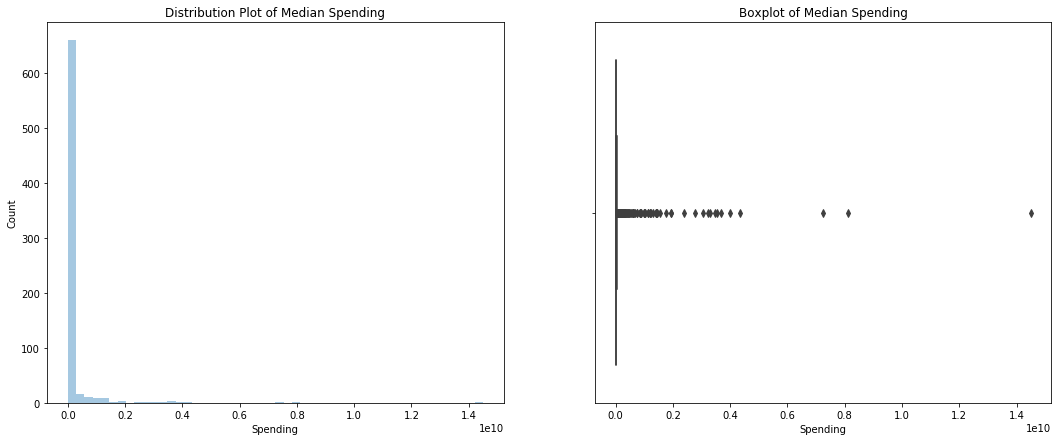

In [8]:
plt.figure(figsize = (18, 7))

plt.subplot(1, 2, 1)
sns.distplot(df['median'], kde = False)
plt.title('Distribution Plot of Median Spending')
plt.xlabel('Spending')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(df['median'])
plt.title('Boxplot of Median Spending')
plt.xlabel('Spending')

plt.show()

### 1.3 Qualitatively describe the distribution of the logarithm of the median annual spending. Plot the histogram.

* The values for the summary statistics of the log(median) are shown below

__Steps taken to obtain the data for the plots of the logarithm of the median annual spending__

* While taking the logarithm of the median annual spending, some values returned as -inf and NaN so the datafrane had to subsetted to remove those values. The cause of that was because a couple of the median values were 0 or negative.
* To visualize the distribution for the log of the median annual spending, a distribution plot and boxplot were created.
* Compared to the previous plots, the distribution seems more normally distributed. 

In [9]:
df2['median_log'].describe()

count    714.000000
mean      14.235102
std        3.396376
min        6.445720
25%       11.647108
50%       13.930871
75%       16.441510
max       23.397100
Name: median_log, dtype: float64

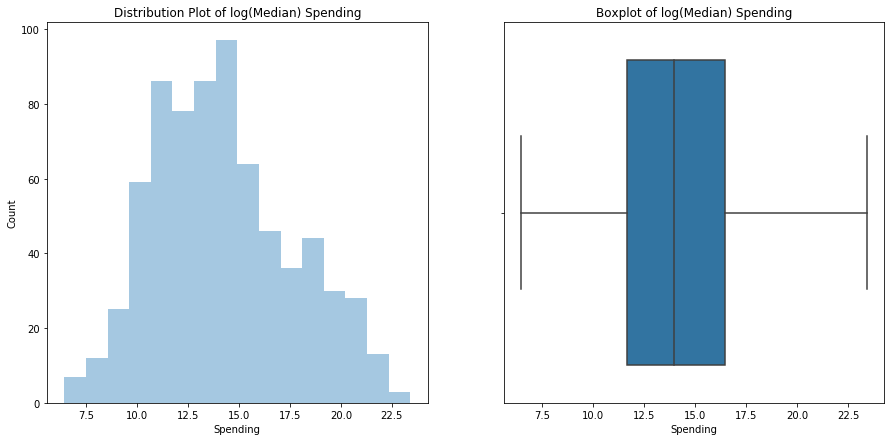

In [10]:
plt.figure(figsize = (15, 7))

plt.subplot(1, 2, 1)
sns.distplot(df2['median_log'], kde = False)
plt.title('Distribution Plot of log(Median) Spending')
plt.xlabel('Spending')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(df2['median_log'])
plt.title('Boxplot of log(Median) Spending')
plt.xlabel('Spending')

plt.show()

### 1.4 Is there a clear separation between agencies that spend a large amount of money, and those which spend less money?

* From the plots shown in 1.3, I don't see a clear separation between agencies that spend a large amount of money and those which spend less money. Maybe for the first graph, organizations that spend a lot of money do so less frequently. 

### 2.1 Qualitatively describe the distribution of the file sizes

* The values for the summary statistics of the file sizes are shown below
* To visualize the distribution of file sizes, a distribution plot and boxplot were created
* Similar to the plots of the median, the distribution for file sizes are also heavily right skewed with a couple extreme outliers

In [11]:
df['file_size'].describe()

count    7.200000e+02
mean     7.195041e+06
std      7.839927e+07
min      1.890000e+02
25%      7.760000e+02
50%      9.195000e+03
75%      2.416998e+05
max      1.798441e+09
Name: file_size, dtype: float64

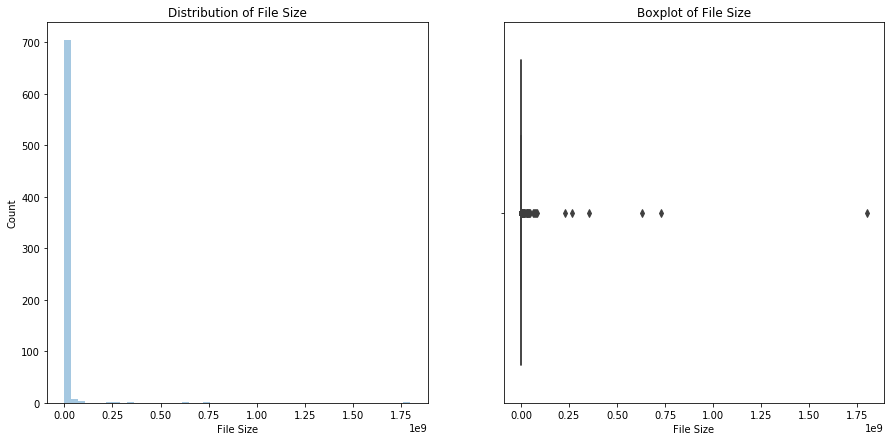

In [12]:
plt.figure(figsize = (15, 7))

plt.subplot(1, 2, 1)
sns.distplot(df['file_size'], kde = False)
plt.title('Distribution of File Size')
plt.xlabel('File Size')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(df['file_size'])
plt.title('Boxplot of File Size')
plt.xlabel('File Size')

plt.show()

### 2.2 How does the size of the file relate to the number of rows in that file?

* To visualize the relationship between file size and row count, a scatterplot was created along with a regression line
* From the plot shown below, the file size generally relates to how many rows are in the file
* A small file_size corresponds to a small row_count and similarly a large file_size corresponds to a large row_count (positive linear relationship)

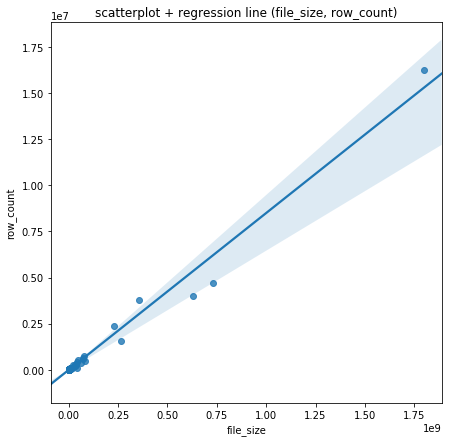

In [13]:
plt.figure(figsize = (7, 7))

sns.regplot(df['file_size'], df['row_count'])
plt.title('scatterplot + regression line (file_size, row_count)')

plt.show()

### 2.3 How long does it take to process all the data?

* It takes around 3 to 4 minutes or so to process all the data (excluding 0.csv) 

In [14]:
end_time = datetime.datetime.now()
run_time = end_time - start_time
time_difference_in_minutes = run_time / datetime.timedelta(minutes = 1)

print('time taken to process all the data in minutes (excluding 0.csv): ', time_difference_in_minutes)

time taken to process all the data in minutes (excluding 0.csv):  4.004416483333333


### 2.4 Do you think this same approach you took works for 10 times as many files? What if each file was 10 times larger?

* The approach itself would work for both 10 times as many files and files that are 10 times larger
* The time it would take would depend on how large those files are. If each file was 10 times longer, I wouldn't be surprised if the same process I used took multiple hours.

### 2.5 How do you imagine you could make it faster?

* Buy a supercomputer
* (?) Work with multiple computers with each working on a subset of the zip file, then save the data from each computer and compile it on 1 computer (?)
